In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn import metrics
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

# Question 1

In [2]:
data_path = '/Users/alisaaa/Desktop/Stats 3DA/assignment/assign6/chronic_kidney_disease.arff'

# Read the arff data file
with open(data_path, 'r') as f:
    data = f.readlines()
    # Extract Headers
    header = [line for line in data if line.startswith('@attribute')]
    # Parse Headers
    header_to_type = {}
    for line in header:
        colname = line.split()[1][1:-1]
        coltype = line.split()[2]
        if coltype == "numeric":
            header_to_type[colname] = float
        else:
            header_to_type[colname] = str
    # Extract Data
    data = [line.strip() for line in data if line.strip() and not line.startswith('@')]
    data = [line.split(',') for line in data]
    # Fix length 26 columns
    data = [[x.strip() for x in line if x.strip()] for line in data]


# Create a pandas dataframe
df = pd.DataFrame(data, columns=list(header_to_type.keys()))
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


Based on this dataset, we can define the classification problem as predicting whether the patient is a Chronic Kidney Disease patient or not. To describe in details. Each dependent variable "class" is based on all other independent variables. In other words, the dataset consists of a collection of medical records of patients. Age, blood pressure(bp), specific gravity(sg), etc. are the features in dataset. These features will be used to predict the dependent variable (ckd or norckd).

# Q2

In [5]:
df_clean = df.copy()


# Convert numeric columns to float, and categorical columns to string
for col, col_type in header_to_type.items():
    if col_type == float:
        # Convert ? to np.nan
        df_clean[col] = df_clean[col].replace('?', np.nan)
        df_clean[col] = df_clean[col].astype(float)
    else:
        df_clean[col] = df_clean[col].astype(str)
        # Convert ? to np.nan
        df_clean[col] = df_clean[col].replace('?', np.nan)

df_clean.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1,0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


# Q3

In [6]:
# Full statistics
df_clean.describe(include='all')

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,391.000000,388.000000,353,354,351,248,335,396,396,356.000000,...,329.000000,294.000000,269.000000,398,398,398,399,399,399,400
unique,NaN,NaN,5,6,6,2,2,2,2,NaN,...,NaN,NaN,NaN,2,2,2,2,2,2,2
top,NaN,NaN,1.020,0,0,normal,normal,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,no,no,good,no,no,ckd
freq,NaN,NaN,106,199,290,201,259,354,374,NaN,...,NaN,NaN,NaN,251,261,364,317,323,339,250
mean,51.483376,76.469072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.036517,...,38.884498,8406.122449,4.707435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,17.169714,13.683637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.281714,...,8.990105,2944.474190,1.025323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,...,9.000000,2200.000000,2.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,42.000000,70.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,...,32.000000,6500.000000,3.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,55.000000,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.000000,...,40.000000,8000.000000,4.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,64.500000,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.000000,...,45.000000,9800.000000,5.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Descriptive statistics
df_clean.describe()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


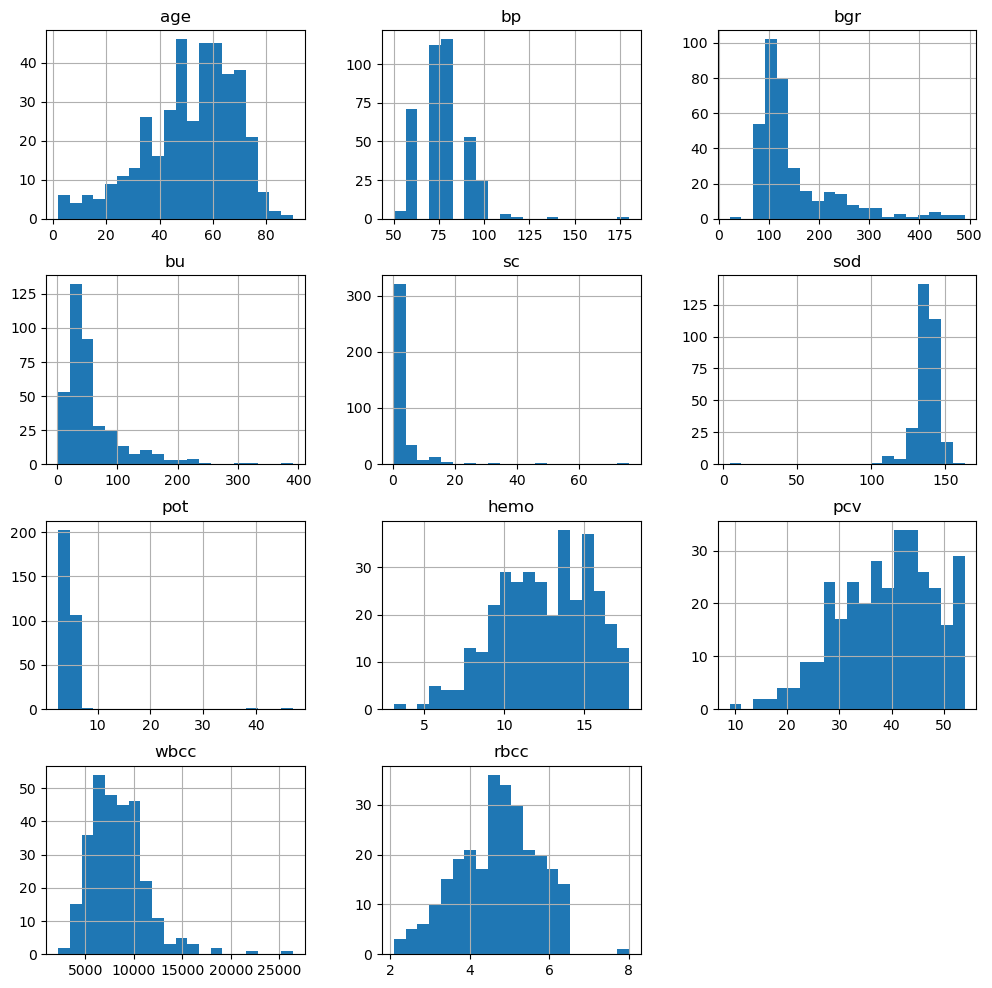

In [8]:
# Distribution of descriptive statistics
df_numeric = df_clean.select_dtypes(include=[np.number])
df_numeric.hist(figsize=(12, 12), bins=20)
plt.show()

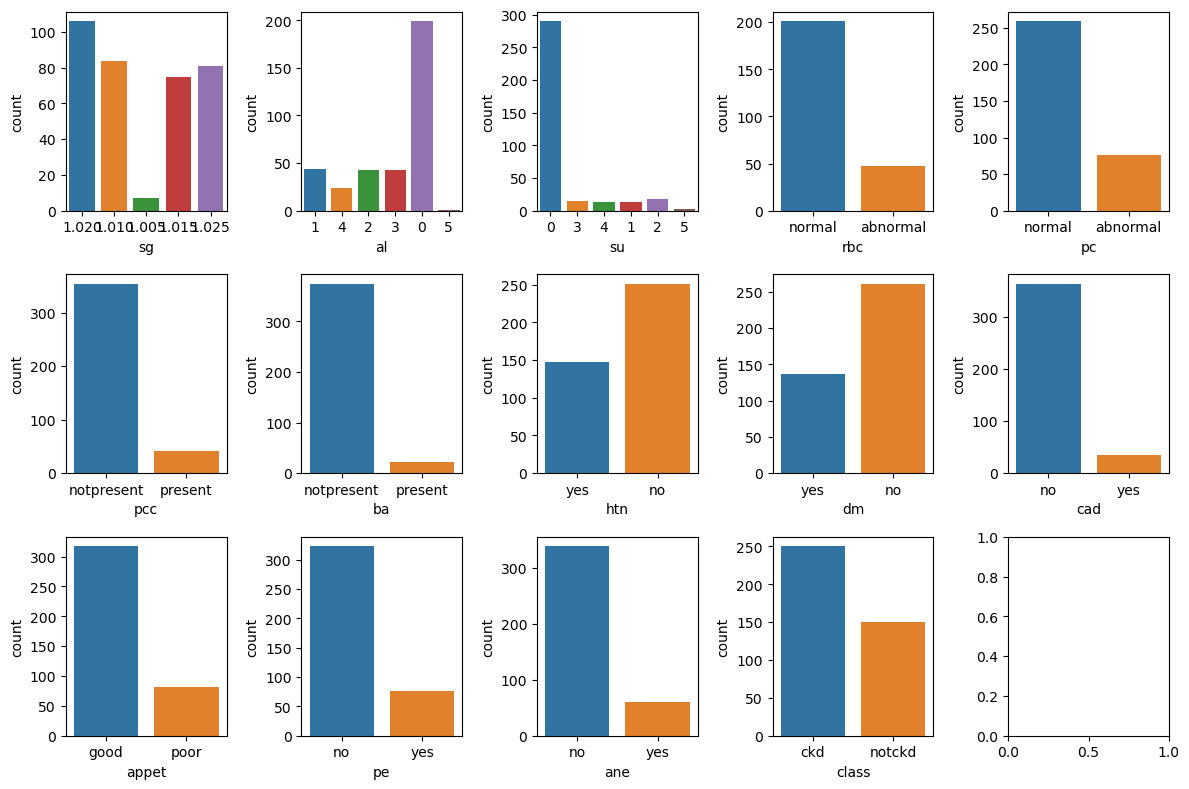

In [9]:
# Distribution of categorical statistics
df_categorical = df_clean.select_dtypes(include=[object])
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(df_categorical.columns):
        sns.countplot(x=df_categorical.columns[i], data=df_categorical, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
df_clean.shape

(400, 25)

In [13]:
df_clean.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [12]:
df_clean.dtypes

age      float64
bp       float64
sg        object
al        object
su        object
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

**Statements**
1. There are 400 observations and 25 variables in the dataset.

2. Independent variables in the dataset are age, blood pressure, specific gravity, albumin, sugar, red blood cells, pus cell, pus cell clumps, bacteria, blood glucose random, blood urea, serum creatinine, sodium, potassium, hemoglobin, packed cell volume, white blood cell count, red blood cell count, hypertension, diabetes mellitus, coronary artery disease, appetite, pedal edema, anemia, and target variable "class"(ckd or ckdnot)

3. The distribution of categoricals is not balanced, for many categorical columns, there is a dominant category that has a much higher frequency than the others. And the overall distribution of numerical columns is fairly normal, no significant outlier is observed from the data.

4. About variable type, there are 11 floating numbers like age, bp, etc. and others are objects like class, ane, and so on.

# Q4

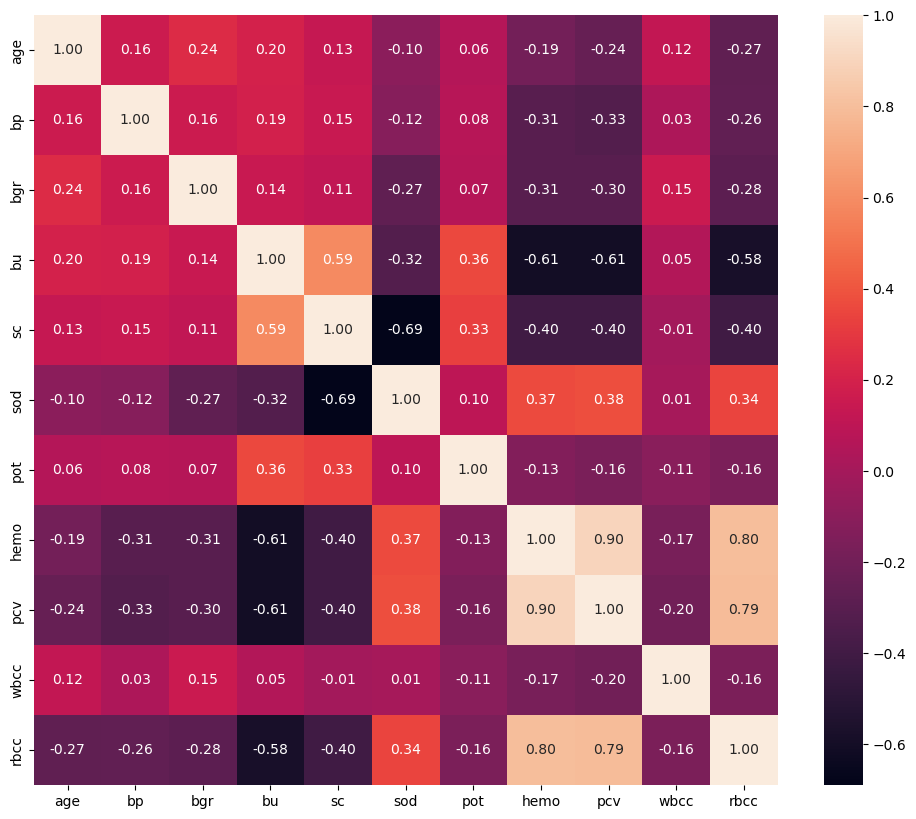

In [15]:
# Check correlation between numeric columns
corr = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

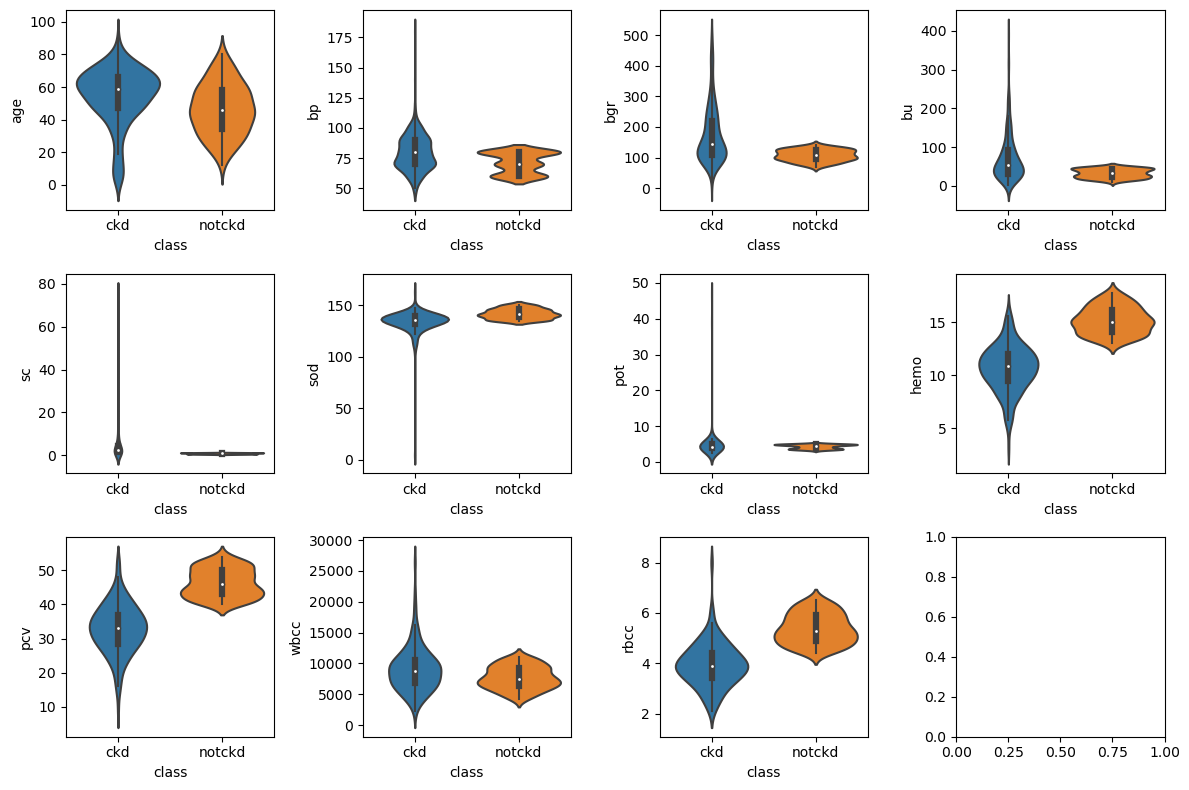

In [18]:
# A categorical and continuous variables - violin plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(df_numeric.columns):
        sns.violinplot(x='class', y=df_numeric.columns[i], data=df_clean, ax=ax)
plt.tight_layout()
plt.show()

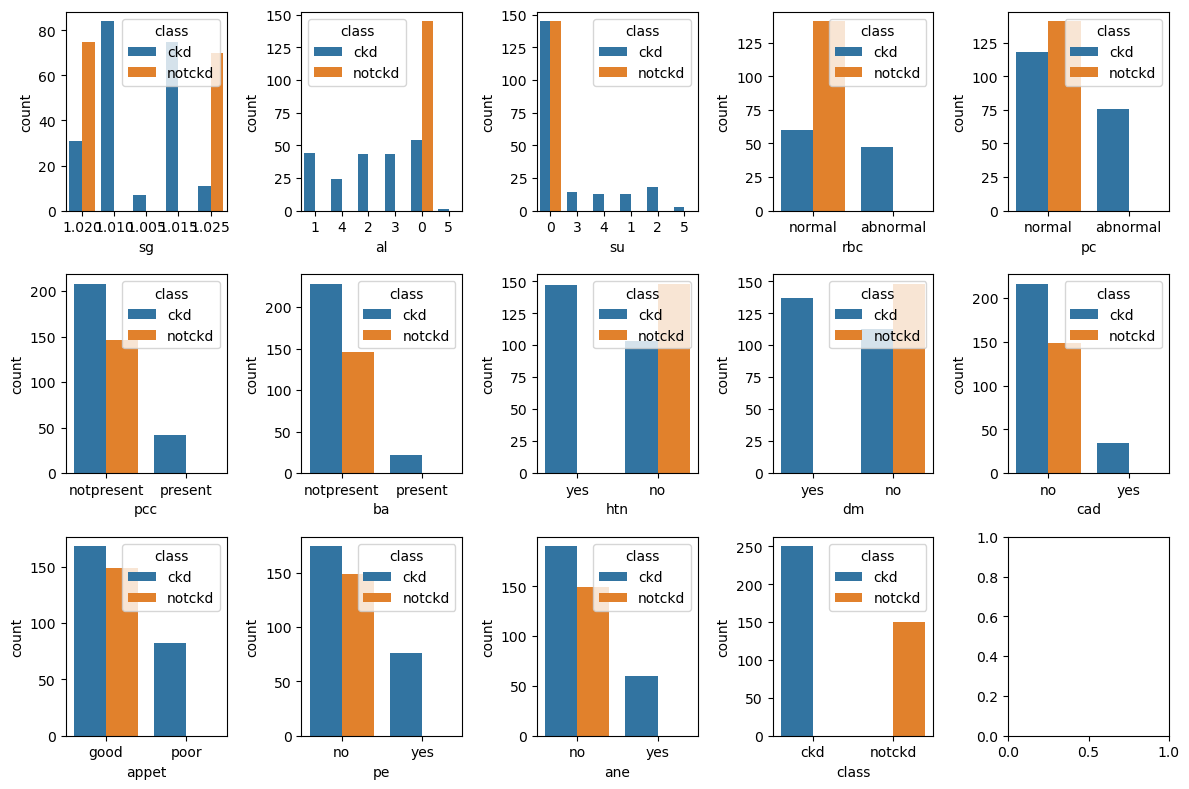

In [19]:
# Bar plot of each categorical column colored by class
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(df_categorical.columns):
        sns.countplot(x=df_categorical.columns[i], data=df_clean, hue='class', ax=ax)
plt.tight_layout()
plt.show()

1. From the heatmap, we see that column "pcv", "hemo", "bu" are the major sources of correlation. We can consider to remove these columns to avoid multicollinearity. However, they can be useful for imputing missing values.

2. From the violin plot, we figure out all the numerical columns are visually related with the target column, that means we can achieve a good classification model out of these features.  The "pot" column is possibly a good feature, since some CKD patients appear to have very high potassium levels.

3. From the bar plots, all the categorical columns are also related to the target column. The count bar plot shows that the distribution of the categorical columns is different for both classes.

# Q5

In [20]:
# Identify columns with missing values
cols_with_missing_values = df_clean.columns[df_clean.isnull().any()].tolist()
print(cols_with_missing_values)

['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


All features have missing values.

For **numerical columns**, a multivariate imputation method will be used, considering that many numerical columns are correlated with each other. For multivariate imputation, we will use the IterativeImputer from the sklearn library. This method is based on the MICE algorithm, which iteratively imputes the missing values of each feature using a simple regression model from other features.

For **categorical columns**, notice that from the previous plots, we see that each categorical column is very important for the classification, that is, appearance of some categories can be a strong indicator of whether the patient is a CKD patient or not. Therefore, considering the importance of the categorical columns, no imputation will be performed. For later analysis, after we convert the categorical columns to dummy variables, missing values will fill the dummy columns with zeros, so that it will not affect our final conclusion about the indicators of the CKD patients.

Therefore:

In [22]:
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
df_numeric = df_clean[numerical_cols]

imputer = IterativeImputer(estimator=LinearRegression())
df_clean.loc[:, numerical_cols] = imputer.fit_transform(df_numeric)

# Q6

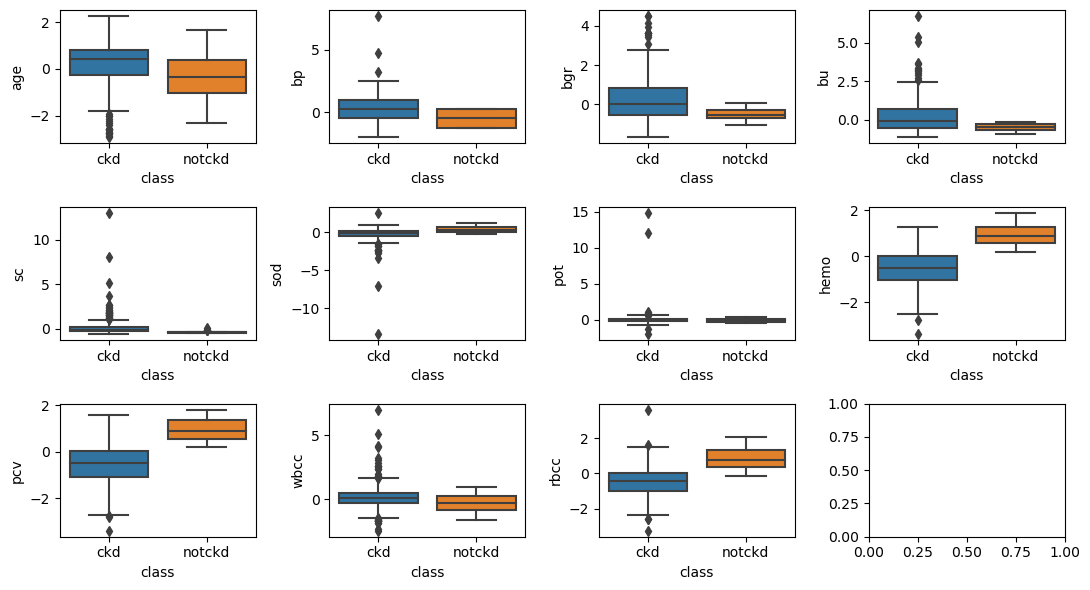

In [23]:
# Standardize the numeric columns
scaler = StandardScaler()
df_outlier = df_clean.copy()
df_outlier.loc[:, numerical_cols] = scaler.fit_transform(df_numeric)

# Box and whisker plot of standardized numeric columns
fig, axes = plt.subplots(3, 4, figsize=(11, 6))
for i, ax in enumerate(axes.flat):
    if i < len(df_numeric.columns):
        col = df_numeric.columns[i]
        sns.boxplot(x='class', y=col, data=df_outlier, ax=ax)

plt.tight_layout()
plt.show()

Although outliers are present in the dataset, we will not handle them. This is because observing from the box plot, the appearance of outliers always happen within a single class. That means, this is most likely not a systematic error, but rather a natural variation of the data. These outliers are also strong indicators of the CKD patients, so we will keep them in the dataset.

# Q7

In [25]:
df_final = df_clean.copy().drop('class', axis=1)
numerical_cols = df_final.select_dtypes(include=[np.number]).columns

# Standardize the numeric columns
scaler = StandardScaler()
numerical_cols = df_final.select_dtypes(include=[np.number]).columns
df_final.loc[:, numerical_cols] = scaler.fit_transform(df_final[numerical_cols])

# Convert categorical columns to one-hot encoding
categorical_cols = df_final.select_dtypes(include=[object]).columns
dummy_df = pd.get_dummies(df_final[categorical_cols])
df_final = pd.concat([df_final, dummy_df], axis=1)
df_final = df_final.drop(categorical_cols, axis=1)

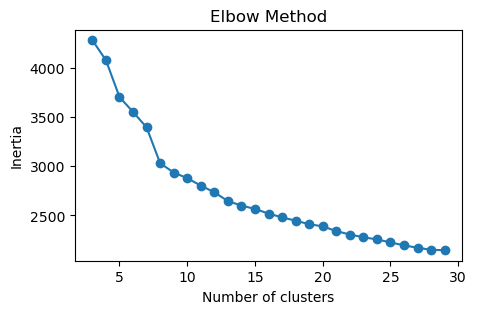

In [26]:
# Elbow method
ks = np.arange(3, 30)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(df_final)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(5, 3))
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

From the above elbow plot, the optimal choice should be 8. In order to identify the characteristics of the subgroups, we can compute summary statistics for each cluster.

#Q8
